# The Wikipedia Game
The goal of this project is to build an algorithm that is able to perform better than a random player at the wikipedia game! The wikipedia game is [INSERT INFO ABOUT WIKIPEDIA GAME]. 

We've broken the project into three main technical challenges
* Scrape wikipedia (or at least a subset) in order to build a data structure with information about what links exist between pages.
* Use graph algorithms to learn cool things about our graph (including the shortest distance between two pages)!
* Create an algorithm that does not rely on the graph but can still navigate from one page to another in a short distance. Ideally this distance would be equal to the shortest possible distance, but it would be cool if it at least performed better than an algorithm that chooses links randomly.

## Step 1: Scraping Wikipedia
The easiest way to do this would probably have been to rely on the wikipedia data dumps that are released twice monthly. However, we wanted to play with beautiful soup and requests, so we decided to implement the scraping manually. This is much more time intensive (computationally) which means that we are not able to build a graph of all of wikipedia, but we also found it to be way cooler!

Before we could actually scrape wikipedia, we had to decide what data we wanted to store and how we wanted to store it. After looking through a bunch of articles, we found that all wikipedia pages have the same link structure:
```
https://en.wikipedia.org/wiki/[articleTitle]
```
So the article on Star Wars has the link https://en.wikipedia.org/wiki/Star_Wars and the article entitled "The Hitchhiker's Guide to the Galaxy" has the link https://en.wikipedia.org/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy (notice how the apostraphe is handled!).

This meant that as long as we stored the article title, we could always recreate the link for the article.


In [114]:
import requests
from bs4 import BeautifulSoup     

PARSER = "lxml"

title_0 = r"The_Hitchhiker%27s_Guide_to_the_Galaxy"
wiki_url = "https://en.wikipedia.org/wiki/" + title_0
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,PARSER)

print(f"The title of the requested page is {soup.title}")

The title of the requested page is <title>The Hitchhiker's Guide to the Galaxy - Wikipedia</title>


Now the question is how do we find all of the article names linked to within a given article?

In [115]:
# First let's get the first 10 <a> html elements
a_elements = soup.find_all('a')[:10]

In [116]:
# Let's extract the href part of each <a> element
links = []
for element in a_elements:
    links.append(element.get('href'))

print(links)


[None, '/wiki/File:The_Hitchhikers_Guide_to_the_Galaxy_Part_1.ogg', '#mw-head', '#searchInput', '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy_(disambiguation)', '/wiki/Hitchhiker%27s_Guide_(disambiguation)', '/wiki/File:H2G2_UK_front_cover.jpg', '/wiki/Douglas_Adams', '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy_Primary_and_Secondary_Phases', '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy:_The_Original_Radio_Scripts']


Clearly all of the links that start with "/wiki/" are wikipedia pages! So let's filter out everything else

In [117]:
clean_links = []
for link in links:
    if (link and link[:6] == "/wiki/"):
        clean_links.append(link)

links = clean_links.copy()
links

['/wiki/File:The_Hitchhikers_Guide_to_the_Galaxy_Part_1.ogg',
 '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy_(disambiguation)',
 '/wiki/Hitchhiker%27s_Guide_(disambiguation)',
 '/wiki/File:H2G2_UK_front_cover.jpg',
 '/wiki/Douglas_Adams',
 '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy_Primary_and_Secondary_Phases',
 '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy:_The_Original_Radio_Scripts']

We probably also don't want the Files. Let's get rid of these two

In [118]:
clean_links = []
for link in links:

    # We found that any link with a : in it is not a "regular" wikipedia
    # Page so we exclude them all
    if (link and link.find(":") == -1):
        clean_links.append(link)

links = clean_links.copy()
links

['/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy_(disambiguation)',
 '/wiki/Hitchhiker%27s_Guide_(disambiguation)',
 '/wiki/Douglas_Adams',
 '/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy_Primary_and_Secondary_Phases']

We combined this scraping and filtering into our `get_wiki_graph_one_step` function. It takes a list of wikipedia article titles. It returns a dictionary where each article is a key and the corresponding value is a list of all the articles linked to within that article.

In [120]:
from scraping import get_wiki_graph_one_step, get_wiki_graph

title_1 = "Star_Wars"
d = get_wiki_graph_one_step([title_0, title_1])

print()
print(f"{title_0} links to {len(d[title_0])} other wikipedia articles")
print(f"For example, within the {title_0} article, there are links to the following wikipedia pages:")
for i in range(0,min(10, len(d[title_0]))):
    print(f"\t{d[title_0][i]}")

print()
print(f"{title_1} links to {len(d[title_1])} other wikipedia articles")
print(f"For example, within the {title_1} article, there are links to the following wikipedia pages:")
for i in range(0,min(10, len(d[title_1]))):
    print(f"\t{d[title_1][i]}")    

(0/2): The_Hitchhiker%27s_Guide_to_the_Galaxy
(1/2): Star_Wars

The_Hitchhiker%27s_Guide_to_the_Galaxy links to 298 other wikipedia articles
For example, within the The_Hitchhiker%27s_Guide_to_the_Galaxy article, there are links to the following wikipedia pages:
	Robbie_Stamp
	The_Hitchhiker%27s_Guide_to_the_Galaxy_(TV_series)
	Peter_Jones_(actor)
	La_Boite_Theatre_Company
	Hyperion_(publisher)
	Alan_J._W._Bell
	Extraterrestrial_life_in_popular_culture
	Zaphod_Beeblebrox
	Miriam_Margolyes
	Saeed_Jaffrey

Star_Wars links to 1258 other wikipedia articles
For example, within the Star_Wars article, there are links to the following wikipedia pages:
	Obi-Wan_Kenobi_(TV_series)
	Military_order_(religious_society)
	Luke_Skywalker_and_the_Shadows_of_Mindor
	Bo-Katan_Kryze
	Kathleen_Kennedy_(producer)
	The_Ewok_Adventure
	Action_Man_(1993%E2%80%932006_toyline)
	Avalon_Hill
	List_of_Star_Wars_Rebels_characters
	Star_Wars_Tales


Above, we just requested the star wars wikipedia page. But in order to build a bigger graph, we could then repeat the same process for all of the pages referenced in the star wars page. We could continue to repeat this process for as many steps as we'd like.

Let's try this:

In [3]:
title = "New_York_State_Route_373"
out = get_wiki_graph(starting_refs=[title], num_steps=2)

(0/1): New_York_State_Route_373
(0/59): The_New_York_Times
(1/59): Numbered_highways_in_New_York
(2/59): Lake_Champlain
(3/59): United_States
(4/59): 52nd_New_York_State_Legislature
(5/59): Vermont
(6/59): Parkways_in_New_York
(7/59): ISBN_(identifier)
(8/59): Main_Page
(9/59): Theodore_Roosevelt_International_Highway
(10/59): Ausable_Chasm
(11/59): American_Antiquarian_Society
(12/59): Canadian_Pacific_Railway
(13/59): New_York_State_Legislature
(14/59): Keeseville,_New_York
(15/59): Hamlet_(New_York)
(16/59): St._Lawrence_County,_New_York
(17/59): List_of_reference_routes_in_New_York
(18/59): Burlington,_Vermont
(19/59): New_York_State_Route_374
(20/59): Plattsburgh,_New_York
(21/59): General_Drafting
(22/59): Ausable_Chasm,_New_York
(23/59): U.S._Route_9_in_New_York
(24/59): County_Route_17_(Essex_County,_New_York)
(25/59): Standard_Oil_Company_of_New_York
(26/59): List_of_Interstate_Highways_in_New_York
(27/59): Burlington%E2%80%93Port_Kent_Ferry
(28/59): Portland,_Oregon
(29/59): 

In [11]:
d = out[0]
print(f"{title} has {len(d[title])} links")

title_1 = d[title][0]
print(f"One such link is {title_1} which itself has {len(d[title_1])} links all of which link out to other articles")


New_York_State_Route_373 has 60 links
One such link is The_New_York_Times which itself has 927 links all of which link out to other articles


Above we did this for two steps. In the first step we found all of the links in `New_York_State_Route_373`. In the second step we found all of the links within all of these links.

In [13]:
print(f"If we were to do the third step, we would have to find all of the links within {len(out[2])} wikipedia articles")

print(f"Given that this takes about 0.5 seconds per article, just three steps would take {len(out[2])*0.5} seconds or {len(out[2])*0.5/3600} hours")

If we were to do the third step, we would have to find all of the links within 19530 wikipedia articles
Given that this takes about 0.5 seconds per article, just three steps would take 9765.0 seconds or 2.7125 hours


With every additional step we take beyond the initial article, the time to build the graph increases exponentially. Since we didn't want our personal computers to be occupied for multiple days, we did this on the Pomona servers using the `scraping.py` file we wrote. The final product was a .json file with [DESCRIBE NUMBER OF ENTRIES]. In the next section, we will be working with this json to build cool graph visualizations and algorithms

## Step 2: Graph Algorithms

In [81]:
import json

f = open("wiki_graph_NYSR_2.json")

d = json.load(f)

In [83]:
wanted_keys = list(d.keys())[:2]
sd = dict((k, d[k]) for k in wanted_keys if k in d)

In [89]:
sd.keys()

dict_keys(['New_York_State_Route_373', '52nd_New_York_State_Legislature'])

In [95]:
import networkx as nx
g = nx.DiGraph(d)

In [97]:
g['Google']

AtlasView({'New_York_State_Route_373': {}, 'Google_Wave_Federation_Protocol': {}, 'Nuclear_power_plant': {}, 'Illinois': {}, 'Pixel_3a': {}, 'Razer_Inc.': {}, 'Android_Developer_Lab': {}, 'NEC': {}, 'Dow_Jones_%26_Company': {}, 'RCA': {}, 'Google_Alerts': {}, 'Fairchild_Semiconductor': {}, 'New_York_City': {}, 'Computer_hardware': {}, 'Metaweb': {}, 'Google_Lively': {}, 'Chile': {}, 'Socratic_(Google)': {}, 'HTC': {}, 'Microsemi': {}, 'Google_Contacts': {}, 'Ken_Auletta': {}, 'Robotics': {}, 'KLA-Tencor': {}, 'Vivo_(technology_company)': {}, 'Tax_avoidance': {}, 'Google_Code_Search': {}, 'Android_One': {}, 'Googlization': {}, 'Project_Starline': {}, 'Google_Travel': {}, 'Gustavo_Guti%C3%A9rrez': {}, 'Knol': {}, 'Republic_of_Ireland': {}, 'Oregon': {}, 'Team_FREDNET': {}, 'Google_Play_Pass': {}, 'Timnit_Gebru': {}, 'LG_Electronics': {}, 'How_Google_Works': {}, 'Proceratium_google': {}, 'Rajen_Sheth': {}, 'Googleshare': {}, 'Google_privacy': {}, 'Google_Lunar_X_Prize': {}, 'Meizu': {}, '

In [41]:
print(nx.shortest_path(g, source="New_York_State_Route_373", target="52nd_New_York_State_Legislature"))
print(nx.shortest_path(g, source="New_York_State_Route_373", target="New_York_State_Legislature"))
print(nx.shortest_path(g, source="New_York_State_Route_373", target="Enos_T._Throop"))
print(nx.all_shortest_paths(g, source="New_York_State_Route_373", target="Google"))
# "Enos_T._Throop"
# New_York_State_Legislature


['New_York_State_Route_373', '52nd_New_York_State_Legislature']
['New_York_State_Route_373', 'New_York_State_Legislature']
['New_York_State_Route_373', '52nd_New_York_State_Legislature', 'Enos_T._Throop']
<generator object _build_paths_from_predecessors at 0x7fb5a4342f20>


In [77]:
g_o = nx.all_shortest_paths(g, source="New_York_State_Route_373", target="Amtrak")

In [79]:
g_o = nx.all_simple_paths(g, source="New_York_State_Route_373", target="Google")

In [74]:
str(g_o)

'<generator object _all_simple_paths_graph at 0x7fb5ef543900>'

In [80]:
print([p for p in g_o])

KeyboardInterrupt: 

In [ ]:
nx.shortest_

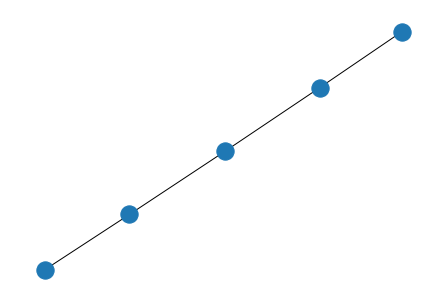

In [29]:
nx.draw(G)

In [26]:
print(nx.shortest_path(g, source="New_York_State_Route_373", target="52nd_New_York_State_Legislature"))


['New_York_State_Route_373', '52nd_New_York_State_Legislature']


In [23]:
import matplotlib.pyplot as plt


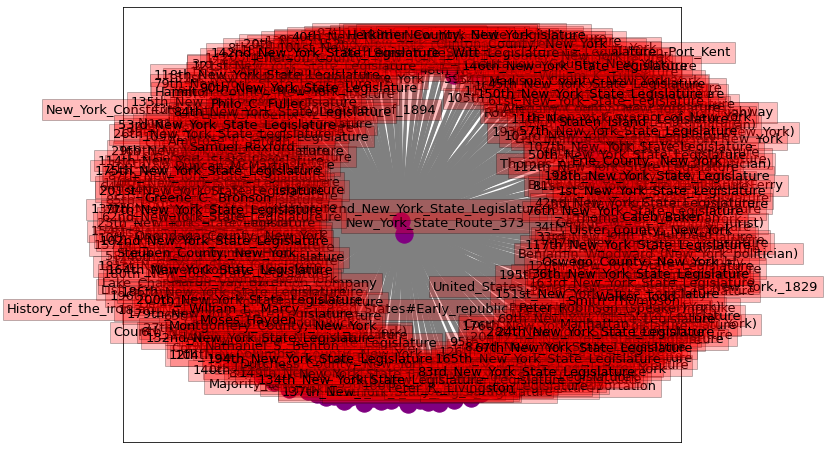

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(g, k=2)

# Plot networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

KeyboardInterrupt: 

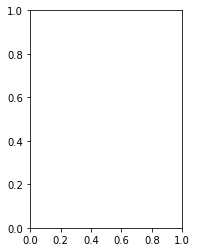

In [11]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(g, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(g, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [14]:
import json

import bs4
from bs4 import BeautifulSoup     
import requests

PARSER = "lxml"            # to use lxml (the most common), you'll need to install with .../pip install lxml

In [15]:
star_wars_url = "https://en.wikipedia.org/wiki/Star_Wars"
response = requests.get(star_wars_url)
data_from_url = response.text
soup = BeautifulSoup(data_from_url,PARSER)


In [16]:
queue = ["Star Wars"]

In [17]:
def get_wiki_graph_one_step(l):
    """
    Takes a list of wikipedia articles with no repeats. 
    Returns A dictionary where keys are items in original list. 
    Values are lists of references to other wikipedia articles
    """
    d = {}
    # s = set()

    for i in range(len(l)):
        title = l[i]
        wiki_url = "https://en.wikipedia.org/wiki/" + title

        # Request Wikipedia and Parse
        response = requests.get(wiki_url)
        data_from_url = response.text
        soup = BeautifulSoup(data_from_url,PARSER)

        print(f"({i}/{len(l)}): {title}")

        # Capture all referenced articles within article
        link_set = set()  # Use a set to ensure no repeats
        for link in soup.find_all('a'):
            s = link.get('href')
            if (s and s[:6] == "/wiki/"):
                ref = s[6:]

                # Make sure that title does not include ":" (means it is not normal wikipedia page)
                if (ref.find(":") == -1):
                    link_set.add(ref)
        d[title] = list(link_set)

    return d

    

In [18]:
def list_of_lists_to_set(lol):
    s = set()
    for l in lol:
        for item in l:
            s.add(item)

    return s

In [ ]:
def save_dict(d, filename):
    # create json object from dictionary
    json_file = json.dumps(d)

    # open file for writing, "w" 
    f = open(filename,"w")

    # write json object to file
    f.write(json_file)

    # close file
    f.close()

In [19]:
def get_wiki_graph(final_d = {}, starting_refs=[], num_steps=1, filename="wiki_graph"):
    if starting_refs:
        ref_list = starting_refs
    else:
        ref_list = ["New_York_State_Route_373"]

    for i in range(num_steps):
        step_d = get_wiki_graph_one_step(ref_list)
        final_d.update(step_d)

        # Get all of the references that haven't been added to graph
        step_refs = list_of_lists_to_set(list(step_d.values()))
        existing_refs = set(final_d.keys())
        unseen_refs = step_refs.difference(existing_refs)

        ref_list = list(unseen_refs)
        
        save_dict(final_d, f"{filename}_{i}.json")

    return (final_d, step_refs, ref_list)

In [21]:
final_d, step_refs, ref_list = get_wiki_graph(starting_refs=["New_York_State_Route_373"], num_steps=4, filename="wiki_graph_NYSR")

(0/1): New_York_State_Route_373
(0/59): Auto_trail
(1/59): Parkways_in_New_York
(2/59): Chesterfield,_New_York
(3/59): Port_Kent_and_Hopkinton_Turnpike
(4/59): Burlington,_Vermont
(5/59): Plattsburgh,_New_York
(6/59): ISBN_(identifier)
(7/59): County_Route_17_(Essex_County,_New_York)
(8/59): 52nd_New_York_State_Legislature
(9/59): Interstate_87_(New_York)
(10/59): Lake_Champlain
(11/59): New_York_State_Legislature
(12/59): Theodore_Roosevelt_International_Highway
(13/59): Baltimore,_Maryland
(14/59): Hopkinton,_New_York
(15/59): New_York_State_Route_372
(16/59): Lake_Champlain_Transportation_Company#Burlington-Port_Kent
(17/59): General_Drafting
(18/59): Lake_Champlain_Transportation_Company
(19/59): Port_Kent_(Amtrak_station)
(20/59): Albany,_New_York
(21/59): New_York_State_Route_374
(22/59): Ausable_Chasm,_New_York
(23/59): Amtrak
(24/59): Toll_gate
(25/59): Hamlet_(New_York)
(26/59): Google_Maps
(27/59): List_of_U.S._Routes_in_New_York
(28/59): Ausable_Chasm
(29/59): Toll_road
(30/

## Step 3: Other Algorithms!

A human being playing the Wikipedia game doesn't have access to the entire graph of Wikipedia pages (if they did, then the game would be a lot easier!) So we wanted to create an algorithm that emulates the behaviour of a human player. When we look for the next link to click, we typically assess how similar each link on a page is to the target page we want to get to. We can do this algorithmically by computing the _semantic similarity_ of each link name with the target page. This yields a greedy algorithm where at each step, we choose the link that is most similar to the target.

In [12]:
# Load the graph

from collections import defaultdict
import json
import numpy as np

with open('wiki_graph.json') as f:
    data = json.load(f)

In [5]:
# Load the language model from Tensorflow
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

2022-04-17 11:09:58.575938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 11:09:58.575962: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-17 11:10:23.376804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-17 11:10:23.376833: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-17 11:10:23.376862: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora-ux333): /proc/driver/nvidia/version does not exist
2022-04-17 11:10:23.377042: I tensorflow/core/platform/cpu_featu

In [9]:
def predict(target, links):
    '''
    Given a target, find the link with highest semantic similarity
    '''
    embeddings = embed([target] + links).numpy()
    cosines = np.dot(embeddings[0], embeddings[1:].T)
    return links[cosines.argmax()]

In [25]:
def search(start, end):
    '''
    Apply the semantic similarity greedy search algorithm to find a path from start to end.
    '''
    path = [start]
    visited = defaultdict(bool)
    visited[start] = True
    current = start

    while current != end:
        links = data[current]
        links = [l for l in links if not visited[l]]
        links = [l for l in links if l in data.keys()]
        current = predict(end, links)

        if current in path:
            print('Got stuck in a loop')
            return path + [current]

        path.append(current)
        visited[current] = True
        print(current)

    return path

In [27]:
search('New York State Route 373', 'American Antiquarian Society')

American Antiquarian Society


['New York State Route 373', 'American Antiquarian Society']

It works for this simple example where the origin page links directly to the target page, so we have a proof of concept!

In [26]:
search('New York State Route 373', 'Henry Louis Gates')

St. Lawrence County, New York
Hopkinton, New York
Adirondack Park
Ausable River (New York)
Keeseville, New York
Chesterfield, New York
Port Kent, New York
Essex County, New York
Albany, New York
Plattsburgh, New York
Lake Champlain Transportation Company
Lake Champlain
New York (state)
New York State Legislature
The New York Times
Main Page


ValueError: attempt to get argmax of an empty sequence

It looks like our graph (which at the moment is a very small subset of the total Wikipedia graph) isn't big enough for longer-paths to work yet. Only one page links to Henry Louis Gates (which is American Antiquarian Society), so if the algorithm doesn't find that page then it gets stuck. In reality, there should be many more pages that link to the target page, so it should have a better chance of finding it.

# Next steps

To continue this project, we need to scrape a larger subset of Wikipedia pages and test our graph search and greedy algorithms on the larger graph. We want to compare their performance on identical start-end points and see if the greedy algorithm can match the performance of the graph search algorithm. It will be interesting to compare their runtimes as well as their minimum-length paths.

This week taught us that looking ahead, we need to focus on scraping a larger graph of Wikipedia pages in order to assess how well the greedy semantic algorithm works. We also want to rework the semantic search algorithm to allow it to backtrack when it reaches a dead end (i.e. a loop or the Main Page), improving the chances of finding the correct page.

We're pretty satisfied with our progress this week, and we think that we're on track to make a pretty cool final project.